In [2]:
DATA_DIR = '../../data/' # for local
# DATA_DIR = 'drive/My Drive/colab/' # for colab

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import MultiTaskElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVR
import xgboost as xgb
import joblib
#import regression_common
#from nilearn.input_data import NiftiMasker
#from nilearn.datasets import load_mni152_brain_mask

#To ensure reproducibility
random.seed(39)
np.random.seed(39)

In [3]:
if False: # to be done once only
    
    # Create/store/load binary image data
    if not os.path.isfile('../data/binary_imgs.npy'):

        dataset_path = "../sample-dataset/HallymBundang_lesionmaps_Bzdok_n1401/"
        img_filenames = glob.glob(os.path.join(dataset_path, '*.nii.gz'))
        img_filenames.sort()
        print('Number of subjects: %d' % len(img_filenames))

        img_shape = load_img(img_filenames[0]).shape

        mask_img = load_mni152_brain_mask()
        masker = NiftiMasker(mask_img=mask_img, memory='nilearn_cache', verbose=5)
        masker = masker.fit()

        imgs = masker.transform(img_filenames) # break down into slices if necessary
        imgs = imgs.astype(bool)
        np.save('../data/binary_imgs', imgs)

    else:
        imgs = np.load('../data/binary_imgs.npy')

    imgs.shape

In [4]:
# Calculate 100 PC components
if not os.path.isfile(DATA_DIR + 'binary_imgs_pc_100.npy'):    
    pca = PCA(n_components=100, copy=False)
    X_pc = pca.fit_transform(imgs)
    np.save(DATA_DIR + 'binary_imgs_pc_100.npy', X_pc)
    
else:
    X_pc = np.load(DATA_DIR + 'binary_imgs_pc_100.npy')
    
X_pc.shape

(1401, 100)

In [5]:
patient_df = pd.read_hdf(DATA_DIR + 'patients.h5', 'p')
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(np.array(patient_df[patient_df.columns[5:11]]))
print(Y.shape)

(1401, 6)


In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(39)

SCORE_DOMAINS = ['Global Cognition', 'Language', 'Visuospatial Functioning', 'Memory',\
                 'Information Processing Speed', 'Executive Functioning']

def calculate_regression_metrics(est_cv, X_train, X_test, y_train, y_test, model_name, score_domain, i_fold):
    
    scores = []
    
    y_predicted_train = est_cv.predict(X_train)
    y_predicted_test = est_cv.predict(X_test)
        
    train_rsq = r2_score(y_train, y_predicted_train)
    test_rsq = r2_score(y_test, y_predicted_test)        

    train_mae = mean_absolute_error(y_train, y_predicted_train)
    test_mae = mean_absolute_error(y_test, y_predicted_test)
    
    scores.append([model_name, score_domain, "R2", "In-sample", i_fold, train_rsq])
    scores.append([model_name, score_domain, "R2", "Out-of-sample", i_fold, test_rsq])
    scores.append([model_name, score_domain, "MAE", "In-sample", i_fold, train_mae])
    scores.append([model_name, score_domain, "MAE", "Out-of-sample", i_fold, test_mae])
    
    return scores
    
    
def run_regression(X, Y, estimator, grid, model_name, random_search_cv=False, n_jobs=-1, random_iter=20, 
                   nn=False, callbacks=None, print_best_params=True):

    scores = []
    best_params = []

    for i_domain in range(Y.shape[1]):

        print('\n' + SCORE_DOMAINS[i_domain] + '\n')
        y = Y[:, i_domain]
        
        kfold_outer = KFold(n_splits=5, shuffle=True, random_state=39)

        i_fold = 1

        for train, test in kfold_outer.split(X):
            
            X_train = X[train]
            X_test = X[test]

            y_train = y[train]
            y_test = y[test]
            
            kfold_inner = KFold(n_splits=5)
            
            if random_search_cv:
                est_cv = RandomizedSearchCV(estimator=estimator, param_distributions=grid, n_jobs=n_jobs,
                                            cv=kfold_inner, random_state=39, n_iter=random_iter, 
                                           )
            else:
                est_cv = GridSearchCV(estimator=estimator, param_grid=grid, n_jobs=n_jobs,
                                      cv=kfold_inner)

            if nn:
                est_cv.fit(X_train, y_train, nn=True, callbacks=callbacks)

            else:
                est_cv.fit(X_train, y_train)

            scores_fold = calculate_regression_metrics(est_cv, X_train, X_test, y_train, y_test, 
                                                       model_name, SCORE_DOMAINS[i_domain], i_fold)
            
            scores.extend(scores_fold)

            best_params.append([model_name, SCORE_DOMAINS[i_domain], i_fold, est_cv.best_params_])

            if print_best_params:
                print('Fold-' + str(i_fold) + ': Best params: ' + str(est_cv.best_params_))

            i_fold += 1


    scores_df = pd.DataFrame(scores, columns=["Model", "Domain", "Metric", "Score type", "Fold", "Score"])    
    best_params_df = pd.DataFrame(best_params, columns=["Model", "Domain", "Fold", "Best params"])
    
    return scores_df, best_params_df


def plot_scores(score_df, score_type, hue_order=None):

    data = score_df[(score_df["Score type"] == score_type)]
    palette = {"Ridge": "C0", "SVR-RBF": "C7", "Random Forest": "C2", "Neural Network": "C4", "XGBoost": "C3"}
    g = sns.catplot(x="Domain", y="Score", hue="Model", col="Metric",
                    data=data, ci="sd", kind="bar", hue_order=hue_order, palette=palette)

    g.set_axis_labels("", "Score (Mean and Standard Deviation across 5 CV folds)")

    for i, ax in enumerate(g.fig.axes):
        ax.set_xticklabels(ax.get_xticklabels(), rotation=65)
        ax.axhline(0, color="black")
        ax.axhline(0.2, color="black")

    g.fig.suptitle("Regression results: " + score_type, y=1.08, fontsize=30)

    if score_type == "Out-of-sample":
        g.set(ylim=(-0.2, 0.2))
    if score_type == "In-sample":
        g.set(ylim=(-0.1, 1.1))
    
#     g.set(ylim=(-0.2, 0.4))

def plot_all_scores(score_df, hue_order=None):
    plot_scores(score_df, "Out-of-sample", hue_order=hue_order)
    plot_scores(score_df, "In-sample", hue_order=hue_order)

### Ridge

In [20]:
def run_ridge_regr(X, Y):   
    estimator = Ridge() 
    alpha = np.append(np.linspace(1000, 600000, 3000), np.linspace(2050000, 2200000, 100))
    grid = {"alpha": alpha}   
    return run_regression(X, Y, estimator, grid, "Ridge", print_best_params=True)


In [21]:
scores_df_ridge, best_params_df_ridge = run_ridge_regr(X_pc, Y)


Global Cognition

Fold-1: Best params: {'alpha': 13383.461153717906}
Fold-2: Best params: {'alpha': 10187.729243081027}
Fold-3: Best params: {'alpha': 13383.461153717906}
Fold-4: Best params: {'alpha': 19175.72524174725}
Fold-5: Best params: {'alpha': 14781.593864621542}

Language

Fold-1: Best params: {'alpha': 29961.320440146716}
Fold-2: Best params: {'alpha': 55926.64221407136}
Fold-3: Best params: {'alpha': 23769.589863287765}
Fold-4: Best params: {'alpha': 57125.04168056019}
Fold-5: Best params: {'alpha': 46738.912970990335}

Visuospatial Functioning

Fold-1: Best params: {'alpha': 119441.81393797933}
Fold-2: Best params: {'alpha': 47138.37945981994}
Fold-3: Best params: {'alpha': 41745.58186062021}
Fold-4: Best params: {'alpha': 18576.525508502837}
Fold-5: Best params: {'alpha': 24169.05635211737}

Memory

Fold-1: Best params: {'alpha': 21971.99066355452}
Fold-2: Best params: {'alpha': 36552.51750583528}
Fold-3: Best params: {'alpha': 23569.85661887296}
Fold-4: Best params: {'al

### SVR

In [26]:
def run_svr_rbf_regr(X, Y):
    estimator = SVR(kernel='rbf') 
    grid = { "C": [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], 
             "gamma": np.logspace(-1, 8, 10)}
    return run_regression(X, Y, estimator, grid, "SVR-RBF", print_best_params=True)

In [27]:
scores_df_svr, best_params_df_svr = run_svr_rbf_regr(X_pc, Y)


Global Cognition

Fold-1: Best params: {'C': 1.0, 'gamma': 0.1}
Fold-2: Best params: {'C': 1.0, 'gamma': 0.1}
Fold-3: Best params: {'C': 1.0, 'gamma': 1.0}
Fold-4: Best params: {'C': 1.0, 'gamma': 0.1}
Fold-5: Best params: {'C': 1.0, 'gamma': 0.1}

Language

Fold-1: Best params: {'C': 0.1, 'gamma': 10.0}
Fold-2: Best params: {'C': 0.1, 'gamma': 100.0}
Fold-3: Best params: {'C': 0.1, 'gamma': 0.1}
Fold-4: Best params: {'C': 0.1, 'gamma': 10.0}
Fold-5: Best params: {'C': 0.1, 'gamma': 100.0}

Visuospatial Functioning

Fold-1: Best params: {'C': 10.0, 'gamma': 1000.0}
Fold-2: Best params: {'C': 10.0, 'gamma': 1000.0}
Fold-3: Best params: {'C': 10.0, 'gamma': 100.0}
Fold-4: Best params: {'C': 10.0, 'gamma': 100.0}
Fold-5: Best params: {'C': 10.0, 'gamma': 100.0}

Memory

Fold-1: Best params: {'C': 0.1, 'gamma': 0.1}
Fold-2: Best params: {'C': 0.1, 'gamma': 0.1}
Fold-3: Best params: {'C': 0.1, 'gamma': 0.1}
Fold-4: Best params: {'C': 0.1, 'gamma': 0.1}
Fold-5: Best params: {'C': 0.1, 'gamm

### Random Forest

In [28]:
def run_random_forest_regr(X, Y):
    
    estimator = RandomForestRegressor(random_state=39)

    n_estimators = [800, 1000, 1200, 1400, 1600, 1800]
    max_features = ['auto', 'sqrt', 'log2']
    max_depth = [2, 5, 7, 10, 15, 20, 25, 30, 50, None]
    min_samples_split = [1, 2, 5, 10, 15, 20]
    min_samples_leaf = [1, 2, 4, 8, 12, 15, 18, 21]
    max_samples = [0.2, 0.25, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, None]

    
    grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples': max_samples}
    
    return run_regression(X, Y, estimator, grid, "Random Forest", random_search_cv=True, random_iter=30, print_best_params=True)

In [29]:
scores_df_rf, best_params_df_rf = run_random_forest_regr(X_pc, Y)


Global Cognition

Fold-1: Best params: {'n_estimators': 1600, 'min_samples_split': 15, 'min_samples_leaf': 18, 'max_samples': 0.9, 'max_features': 'log2', 'max_depth': 7}
Fold-2: Best params: {'n_estimators': 800, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_samples': 0.9, 'max_features': 'sqrt', 'max_depth': 7}
Fold-3: Best params: {'n_estimators': 800, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_samples': 0.9, 'max_features': 'sqrt', 'max_depth': 7}
Fold-4: Best params: {'n_estimators': 800, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_samples': 0.9, 'max_features': 'sqrt', 'max_depth': 7}
Fold-5: Best params: {'n_estimators': 800, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_samples': 0.9, 'max_features': 'sqrt', 'max_depth': 7}

Language

Fold-1: Best params: {'n_estimators': 800, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_samples': 0.9, 'max_features': 'sqrt', 'max_depth': 7}
Fold-2: Best params: {'n_estimators': 800, 'min_samples_split'

### XGBoost

In [11]:
# def run_xgboost_regr(X, Y):

#     estimator = xgb.XGBRegressor(objective='reg:squarederror', random_state=39)
#     grid = {'n_estimators'    : [10, 50, 100, 150, 200],
#                 "learning_rate"    : [0.10, 0.15, 0.20, 0.25] ,
#                 "max_depth"        : [ 3, 4, 5, 6, 8, 10],
#                 "min_child_weight" : [ 5, 7, 9, 11, 15 ],
#                 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3],
#                 "booster"          : ['gbtree', 'gblinear',  'dart' ],
#                 "colsample_bytree" : [ 0.1, 0.2, 0.3, 0.4, 0.5 , 0.7, 1 ]}

#     return run_regression(X, Y, estimator, grid, "XGBoost", random_search_cv=True, n_jobs=1, print_best_params=True)


In [ ]:
# scores_df_xgb, best_params_df_xgb = run_xgboost_regr(X_pc, Y)

### Neural Net 

In [16]:
# from keras.wrappers.scikit_learn import KerasRegressor
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping
# from keras.regularizers import l2

# def build_model(l1_units, l2_units, l3_units, lr, l2_reg):
    
#     # maybe more layers will help in mixup?
#     model = Sequential()
#     model.add(Dense(l1_units, input_dim=N_PCA, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(l2_reg)))
#     model.add(Dense(l2_units, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(l2_reg)))
#     #     model.add(Dense(l2_units, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(l2_reg)))
#     #     model.add(Dense(l2_units, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(l2_reg)))
#     #     model.add(Dense(l3_units, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(l2_reg)))
#     model.add(Dense(l3_units, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(l2_reg)))
#     model.add(Dense(1, kernel_initializer='normal', activation=None, kernel_regularizer=l2(l2_reg)))

#     adam = Adam(lr=lr)
#     model.compile(loss='mse', metrics=['mae'], optimizer=adam)
#     return model

# def run_nn_regr(X, Y):
              
#     es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=3, restore_best_weights=True)
#     estimator = KerasRegressor(build_fn=build_model, epochs=100, verbose=0)
    
#     lr = [0.050, 0.025, 0.010, 0.005]
#     l1_units = [25]
#     l2_units = [15]
#     l3_units = [10]
#     l2_reg = [0.20, 0.15, 0.10, 0.05, 0.01, 0.00]
#     batch_size = [1, 2, 4, 8, 16, 32, 64, 128]

#     grid = {'l1_units': l1_units,
#                'l2_units': l2_units,
#                'l3_units': l3_units,
#                'lr': lr,
#                'l2_reg': l2_reg,
#                'batch_size': batch_size}

#     return run_regression(X, Y, estimator, grid, "Neural Network", print_best_params=True, random_search_cv=True, \
#                                                 nn=True, callbacks=[es])


In [17]:
# scores_df_nn, best_params_df_nn = run_nn_regr(X_pc, Y)

In [2]:
# scores_df_all = pd.concat([scores_df_ridge, scores_df_svr, scores_df_rf], ignore_index=True)

# persist results
# scores_df_all.to_hdf('results/results_pca_100_single_output.h5', key='p', mode='w')
scores_df_all = pd.read_hdf('results/results_pca_100_single_output.h5', key='p', mode='r')

In [17]:
# scores_df_all[(scores_df_all["Domain"]=="Information Processing Speed") & (scores_df_all["Metric"]=="R2") & 
#               (scores_df_all["Score type"]=="Out-of-sample") & (scores_df_all["Model"]=="SVR-RBF")]


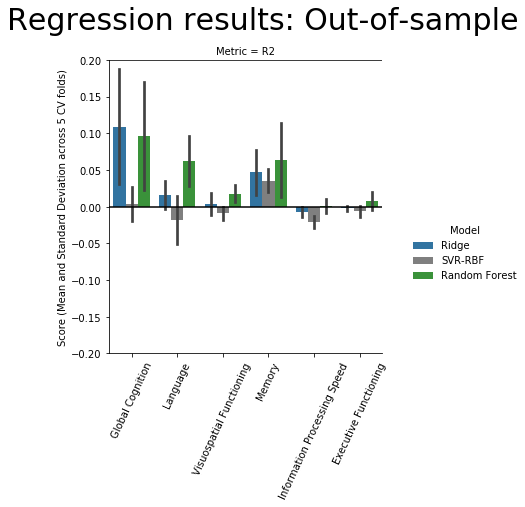

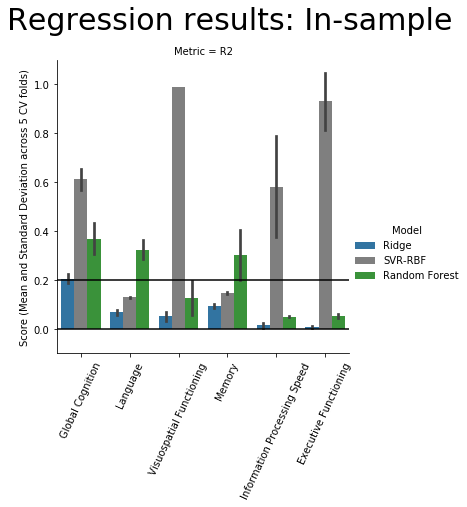

In [37]:
plot_all_scores(scores_df_all[scores_df_all["Metric"]=="R2"])

In [18]:
# plot_all_scores(scores_df_all[(scores_df_all["Model"] == "Ridge") | (scores_df_all["Model"] == "Random Forest")])
# plot_all_scores(scores_df_ridge)